In [ ]:
import torch
from torch import optim
from torch.nn import Sequential,Linear,Sigmoid,BCELoss,MSELoss,Tanh,Conv2d,MaxPool2d,ReLU,Flatten
import  numpy as np
from torchsummary import summary
import pandas as pd

downloading the data

In [ ]:
!wget https://raw.githubusercontent.com/mlampros/DataSets/master/mnist.zip

--2020-11-15 11:03:01--  https://raw.githubusercontent.com/mlampros/DataSets/master/mnist.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15291135 (15M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  14.58M  71.8MB/s    in 0.2s    

2020-11-15 11:03:01 (71.8 MB/s) - ‘mnist.zip’ saved [15291135/15291135]



In [ ]:
!unzip -x mnist.zip

Archive:  mnist.zip
  inflating: mnist.csv               


reading the data from file

In [ ]:

data=pd.read_csv("mnist.csv")
data=np.array(data)
x=data[:,:-1]
y=data[:,-1]
x=x.reshape((len(x),1,28,28))
x=np.array(x)

dividing the data into train,validation, and test

In [ ]:
x_train=[]
y_train=[]
x_val=[]
y_val=[]
x_test=[]
y_test=[]
for number in range(10):
  tmp=[]
  for i in range(len(y)):
    if y[i]==number:
      tmp.append(x[i])
  
  ix_train=int(len(tmp)*0.6)
  ix_val=int(len(tmp)*0.2)
  ###images
  x_train+=tmp[:ix_train]
  x_val+=tmp[ix_train:ix_train+ix_val]
  x_test+=tmp[ix_train+ix_val:]

  ###lables

  one_hot=np.zeros((10,))
  one_hot[number]=1
  for j in range(ix_train):##train
    y_train.append(one_hot)

  for j in range(ix_val):##val
    y_val.append(one_hot)

  for j in range(len(tmp)-ix_train-ix_val):##test
    y_test.append(one_hot)

x_train=torch.tensor(x_train).float().to("cuda")
y_train=torch.tensor(y_train).float().to("cuda")
x_test=torch.tensor(x_test).float().to("cuda")
y_test=torch.tensor(y_test).float().to("cuda")
x_val=torch.tensor(x_val).float().to("cuda")
y_val=torch.tensor(y_val).float().to("cuda")



defining the model

In [ ]:
model=Sequential(Conv2d(in_channels=1,out_channels=32,kernel_size=(3,3),stride=1,padding=1),ReLU(),MaxPool2d(kernel_size=(2,2),stride=2),
                Conv2d(32,64,(3,3),stride=1,padding=1),ReLU(),MaxPool2d(kernel_size=(2,2),stride=2),
                Flatten(),
                Linear(3136,128),
                Linear(128,10),Sigmoid()

                 

)
model.to("cuda")

summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
            Linear-9                   [-1, 10]           1,290
          Sigmoid-10                   [-1, 10]               0
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.61
Estimated T

defining the optimizer

In [ ]:
optimizer = optim.Adam(model.parameters())

training the model

In [ ]:
mse=BCELoss()
rn=np.arange(len(x_train))
dataloader=torch.utils.data.DataLoader(rn, 512, True)
maxi=-1
for epoch in range(20):
  losses=[]
  accuracy_train=[]
  get_batch=iter(dataloader)
  for index in get_batch:
    batch_x=x_train[index]
    batch_y=y_train[index]
    pred=model(batch_x)
    #####update########
    model.train()##switch to trian
    optimizer.zero_grad()
    loss=mse(pred,batch_y)# loss
    loss.backward() #gradient 
    optimizer.step() #
    losses.append(loss.item())

    ####computing accuracy of batch
    pred=pred.argmax(axis=-1)
    target=batch_y.argmax(axis=-1)
    correct=torch.sum(pred==target).item()
    accuracy=correct/len(batch_y)
    accuracy_train.append(accuracy)
  
  

  ####validation 
  model.eval()###swtich to evaluation
  pred=model(x_val)
  loss_val=mse(pred,y_val).item()
  pred=pred.argmax(axis=-1)
  target=y_val.argmax(axis=-1)
  
  ###computing accuracy of validation set
  correct=torch.sum(pred==target).item()
  accuracy_val=correct/len(y_val)
  if accuracy_val>maxi:
    maxi=accuracy_val
    torch.save(model,"model.pth")
  

  print("epoch",epoch,"     loss:",np.mean(losses), "   accuracy_train:",np.mean(accuracy_train),"    loss_val:",loss_val,"    val_accuracy:",accuracy_val)

epoch 0      loss: 8.377377889242517    accuracy_train: 0.10124589266155533     loss_val: 8.29827880859375     val_accuracy: 0.10017147756501858
epoch 1      loss: 5.117485220891884    accuracy_train: 0.2768132187842278     loss_val: 0.11796732991933823     val_accuracy: 0.8203058016576165
epoch 2      loss: 0.060477744799152196    accuracy_train: 0.9196630271084337     loss_val: 0.04189957678318024     val_accuracy: 0.9486281794798513
epoch 3      loss: 0.03133099948067263    accuracy_train: 0.9623600937842278     loss_val: 0.029876668006181717     val_accuracy: 0.9646327522149185
epoch 4      loss: 0.02535852614835084    accuracy_train: 0.9714796686746988     loss_val: 0.025133855640888214     val_accuracy: 0.9703486710488711
epoch 5      loss: 0.020139989027955447    accuracy_train: 0.9773390436746988     loss_val: 0.02223431132733822     val_accuracy: 0.9755644469848528
epoch 6      loss: 0.017403069771377438    accuracy_train: 0.9817159262048193     loss_val: 0.0202876478433609   

[[1.7422282e-14 7.7450189e-16 2.4723027e-14 3.6825679e-14 2.0387587e-08
  3.2324545e-09 2.1832936e-22 1.2841212e-04 1.3488228e-08 9.9905163e-01]]
9


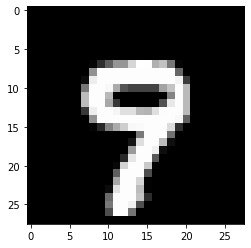

In [ ]:
model.eval()
index=1000
ans=model(x_test[index].reshape((1,1,28,28)))
print(np.array(ans.cpu().detach()))
import matplotlib.pyplot as plt
plt.imshow(x_test[index].reshape((28,28)).cpu(),cmap="gray")
print(ans.argmax().item())


testing the model

In [ ]:
model.eval()
pred=model(x_test)
loss_test=mse(pred,y_test).item()
pred=pred.argmax(axis=-1)
target=y_test.argmax(axis=-1)
  

correct=torch.sum(pred==target).item()
accuracy_test=correct/len(y_test)
print("Accuracy test:",accuracy_test,"    loss_test:",loss_test)

Accuracy test: 0.9862231422656863     loss_test: 0.015352461487054825
